### Final Project: Phone Prices
#### Madison Mina & Dimas Monte

We will be analyzing the "Mobiles Dataset (2025)" by Abdul Malik on Kaggle. This dataset contains 930 rows and 15 columns, with mobile phone specifications such as company, model, RAM, camera configurations, battery capacity, and launch prices across five countries: Pakistan, India, China, the United States, and the UAE. 

Our primary goal is to examine how these technical features relate to the launch price of a phone. To evaluate model performance, we will use a paired t-test to determine whether a features-based regression model significantly reduces prediction error compared to a baseline model that uses only the mean price (null model). This analysis will help assess the feasibility of predicting future phone prices in various countries based on their specifications.


#### Hypothesis

Null Hypothesis (H₀):
The mean squared error from the features model is equal to the baseline.

H₀: μ = 0 
> Same amount of error
> 
Alternative Hypothesis (H₁):
The features model has lower mean squared error than the baseline model.

H₁: μ < 0
> Less error, more accurate
> 
μ represents the mean squared error (MSE)

In [1]:
import pandas as pd

df = pd.read_csv("mobiles_dataset.csv", encoding="latin1")

df.head(10)


,Company Name,Model Name,Mobile Weight,RAM,Front Camera,Back Camera,Processor,Battery Capacity,Screen Size,Launched Price (Pakistan),Launched Price (India),Launched Price (China),Launched Price (USA),Launched Price (Dubai),Launched Year
0,Apple,iPhone 16 128GB,174g,6GB,12MP,48MP,A17 Bionic,"3,600mAh",6.1 inches,"PKR 224,999","INR 79,999","CNY 5,799",USD 799,"AED 2,799",2024
1,Apple,iPhone 16 256GB,174g,6GB,12MP,48MP,A17 Bionic,"3,600mAh",6.1 inches,"PKR 234,999","INR 84,999","CNY 6,099",USD 849,"AED 2,999",2024
2,Apple,iPhone 16 512GB,174g,6GB,12MP,48MP,A17 Bionic,"3,600mAh",6.1 inches,"PKR 244,999","INR 89,999","CNY 6,499",USD 899,"AED 3,199",2024
3,Apple,iPhone 16 Plus 128GB,203g,6GB,12MP,48MP,A17 Bionic,"4,200mAh",6.7 inches,"PKR 249,999","INR 89,999","CNY 6,199",USD 899,"AED 3,199",2024
4,Apple,iPhone 16 Plus 256GB,203g,6GB,12MP,48MP,A17 Bionic,"4,200mAh",6.7 inches,"PKR 259,999","INR 94,999","CNY 6,499",USD 949,"AED 3,399",2024
5,Apple,iPhone 16 Plus 512GB,203g,6GB,12MP,48MP,A17 Bionic,"4,200mAh",6.7 inches,"PKR 274,999","INR 104,999","CNY 6,999",USD 999,"AED 3,599",2024
6,Apple,iPhone 16 Pro 128GB,206g,6GB,12MP / 4K,50MP + 12MP,A17 Pro,"4,400mAh",6.1 inches,"PKR 284,999","INR 99,999","CNY 6,999",USD 999,"AED 3,499",2024
7,Apple,iPhone 16 Pro 256GB,206g,8GB,12MP / 4K,50MP + 12MP,A17 Pro,"4,400mAh",6.1 inches,"PKR 294,999","INR 104,999","CNY 7,099","USD 1,049","AED 3,699",2024
8,Apple,iPhone 16 Pro 512GB,206g,8GB,12MP / 4K,50MP + 12MP,A17 Pro,"4,400mAh",6.1 inches,"PKR 314,999","INR 114,999","CNY 7,499","USD 1,099","AED 3,899",2024
9,Apple,iPhone 16 Pro Max 128GB,221g,6GB,12MP / 4K,48MP + 12MP,A17 Pro,"4,500mAh",6.7 inches,"PKR 314,999","INR 109,999","CNY 7,499","USD 1,099","AED 3,799",2024


In [3]:
# Check the data types for testing
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929 entries, 0 to 928
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Company Name               929 non-null    object
 1   Model Name                 929 non-null    object
 2   Mobile Weight              929 non-null    object
 3   RAM                        929 non-null    object
 4   Front Camera               929 non-null    object
 5   Back Camera                929 non-null    object
 6   Processor                  929 non-null    object
 7   Battery Capacity           929 non-null    object
 8   Screen Size                929 non-null    object
 9   Launched Price (Pakistan)  929 non-null    object
 10  Launched Price (India)     929 non-null    object
 11  Launched Price (China)     929 non-null    object
 12  Launched Price (USA)       929 non-null    object
 13  Launched Price (Dubai)     929 non-null    object
 14  Launched Y

#### Data Preprocessing

In [6]:
# Problem: A lot of object dtypes -> Must clean the data of non-numerical values
import re

def extract_numeric(col):
    # Remove any nonumerical values: commas, parenthesis, letters
    return col.astype(str).apply(lambda x: float(re.search(r"[\d]+(?:\.\d+)?", x.replace(',', '')).group()) 
                                 if re.search(r"[\d]+(?:\.\d+)?", x.replace(',', '')) else None)

def parse_back_camera(col):
    def extract_mps(entry):
        # Catch nulls and non-string entries
        if not entry or pd.isna(entry):
            return [0.0, 0.0, 0.0, 0.0]
        # Extract numbers, allowing for formats like '50MP', '50 MP', etc.
        mps = [float(num) for num in re.findall(r"\d+\.?\d*", str(entry))]
        return (mps + [0.0] * 4)[:4]
    
    return col.apply(extract_mps).apply(pd.Series)

def parse_front_camera(col):
    def extract_mps(entry):
        if not entry or pd.isna(entry):
            return [0.0, 0.0]
        mps = [float(num) for num in re.findall(r"\d+\.?\d*", str(entry))]
        return (mps + [0.0] * 2)[:2]
    
    return col.apply(extract_mps).apply(pd.Series)
    
categorical_features = ["Company Name", "Model Name", "Processor"]
numerical = ["Mobile Weight","RAM","Battery Capacity","Screen Size","Launched Price (USA)"]

# Apply cleaning logic
for col in numerical:
    df[col] = extract_numeric(df[col])

back_df = parse_back_camera(df['Back Camera'])
back_df.columns = ["BackCam_1", "BackCam_2","BackCam_3","BackCam_4"]
df = df.join(back_df)  

front_df = parse_front_camera(df['Front Camera'])
front_df.columns = ["FrontCam_1", "FrontCam_2"]
df = df.join(front_df)

df.head(10)
            

,Company Name,Model Name,Mobile Weight,RAM,Front Camera,Back Camera,Processor,Battery Capacity,Screen Size,Launched Price (Pakistan),...,Launched Price (China),Launched Price (USA),Launched Price (Dubai),Launched Year,BackCam_1,BackCam_2,BackCam_3,BackCam_4,FrontCam_1,FrontCam_2
0,Apple,iPhone 16 128GB,174.0,6.0,12MP,48MP,A17 Bionic,3600.0,6.1,"PKR 224,999",...,"CNY 5,799",799.0,"AED 2,799",2024,48.0,0.0,0.0,0.0,12.0,0.0
1,Apple,iPhone 16 256GB,174.0,6.0,12MP,48MP,A17 Bionic,3600.0,6.1,"PKR 234,999",...,"CNY 6,099",849.0,"AED 2,999",2024,48.0,0.0,0.0,0.0,12.0,0.0
2,Apple,iPhone 16 512GB,174.0,6.0,12MP,48MP,A17 Bionic,3600.0,6.1,"PKR 244,999",...,"CNY 6,499",899.0,"AED 3,199",2024,48.0,0.0,0.0,0.0,12.0,0.0
3,Apple,iPhone 16 Plus 128GB,203.0,6.0,12MP,48MP,A17 Bionic,4200.0,6.7,"PKR 249,999",...,"CNY 6,199",899.0,"AED 3,199",2024,48.0,0.0,0.0,0.0,12.0,0.0
4,Apple,iPhone 16 Plus 256GB,203.0,6.0,12MP,48MP,A17 Bionic,4200.0,6.7,"PKR 259,999",...,"CNY 6,499",949.0,"AED 3,399",2024,48.0,0.0,0.0,0.0,12.0,0.0
5,Apple,iPhone 16 Plus 512GB,203.0,6.0,12MP,48MP,A17 Bionic,4200.0,6.7,"PKR 274,999",...,"CNY 6,999",999.0,"AED 3,599",2024,48.0,0.0,0.0,0.0,12.0,0.0
6,Apple,iPhone 16 Pro 128GB,206.0,6.0,12MP / 4K,50MP + 12MP,A17 Pro,4400.0,6.1,"PKR 284,999",...,"CNY 6,999",999.0,"AED 3,499",2024,50.0,12.0,0.0,0.0,12.0,4.0
7,Apple,iPhone 16 Pro 256GB,206.0,8.0,12MP / 4K,50MP + 12MP,A17 Pro,4400.0,6.1,"PKR 294,999",...,"CNY 7,099",1049.0,"AED 3,699",2024,50.0,12.0,0.0,0.0,12.0,4.0
8,Apple,iPhone 16 Pro 512GB,206.0,8.0,12MP / 4K,50MP + 12MP,A17 Pro,4400.0,6.1,"PKR 314,999",...,"CNY 7,499",1099.0,"AED 3,899",2024,50.0,12.0,0.0,0.0,12.0,4.0
9,Apple,iPhone 16 Pro Max 128GB,221.0,6.0,12MP / 4K,48MP + 12MP,A17 Pro,4500.0,6.7,"PKR 314,999",...,"CNY 7,499",1099.0,"AED 3,799",2024,48.0,12.0,0.0,0.0,12.0,4.0


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

numerical_features = ["Mobile Weight","RAM","Battery Capacity","Screen Size","FrontCam_1", "FrontCam_2","BackCam_1", "BackCam_2","BackCam_3","BackCam_4"]
# Define features and target (for USA price)
X = df[numerical_features]
y = df['Launched Price (USA)']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Data Visualization
Plot the relationship between each feature and the target variable, launch price (USA).

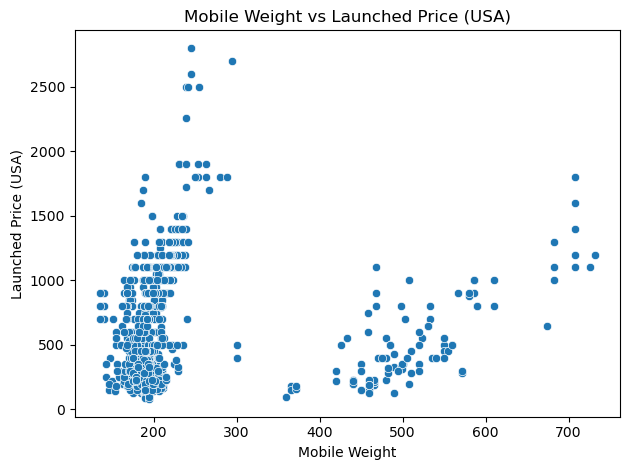

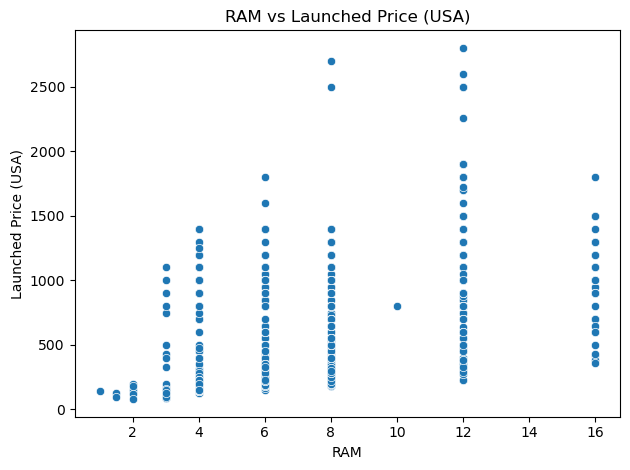

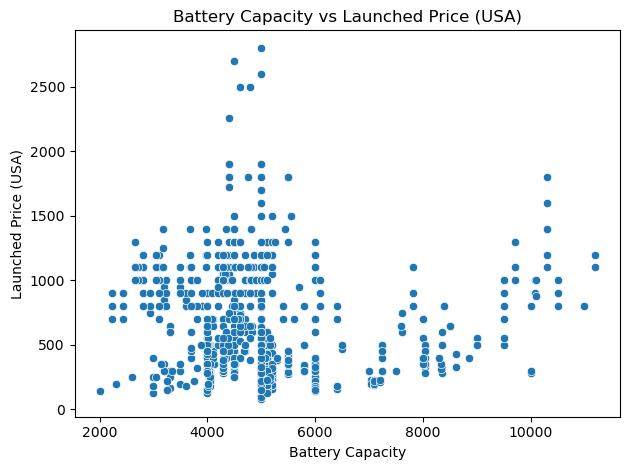

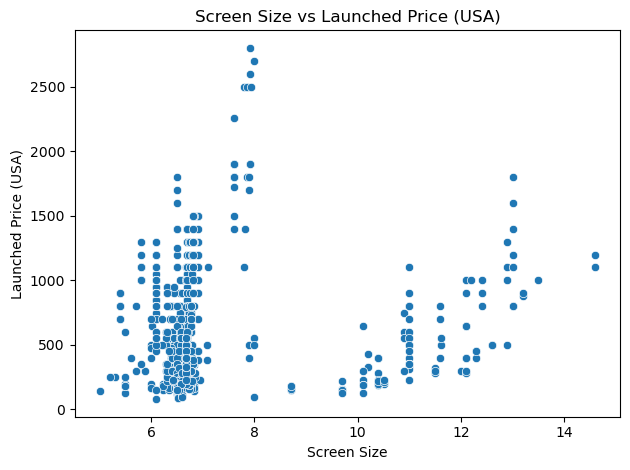

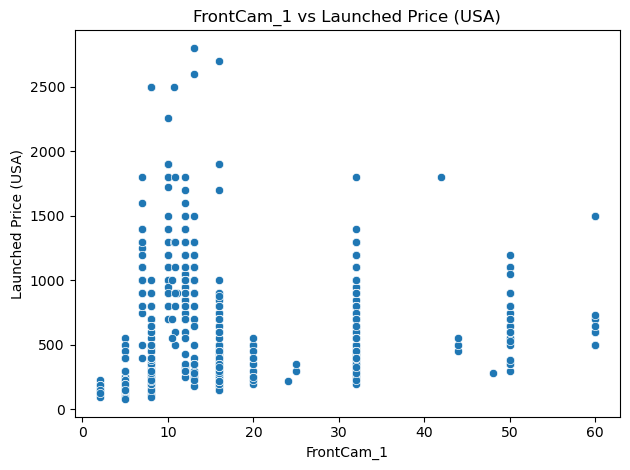

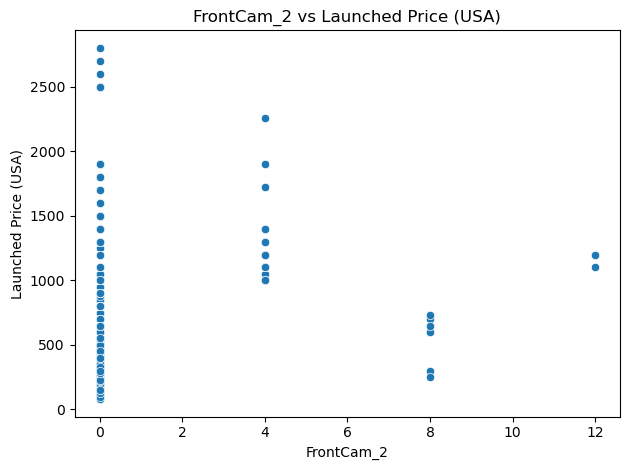

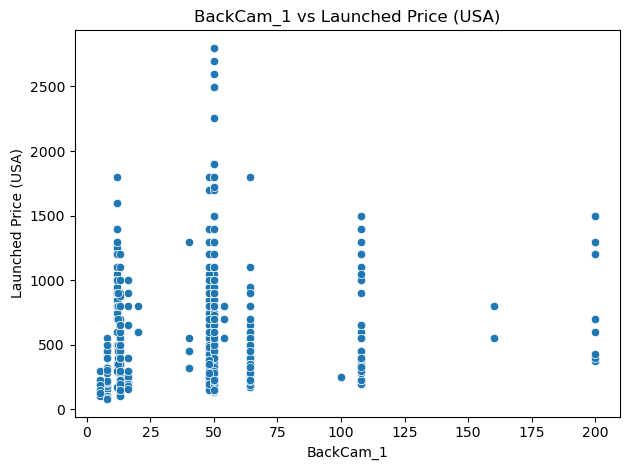

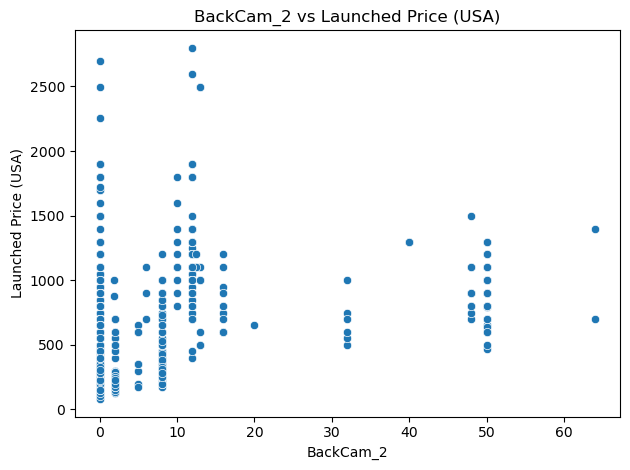

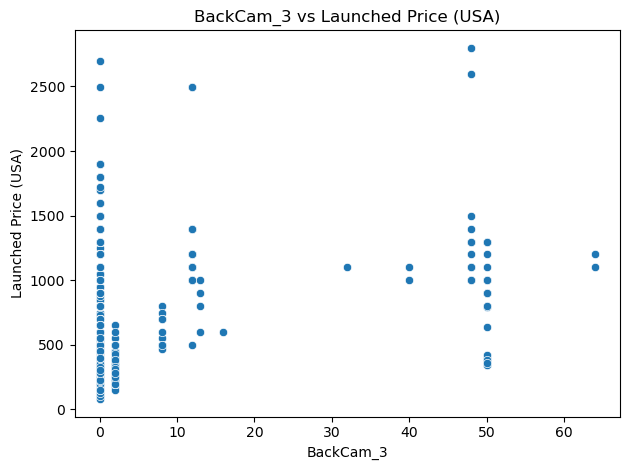

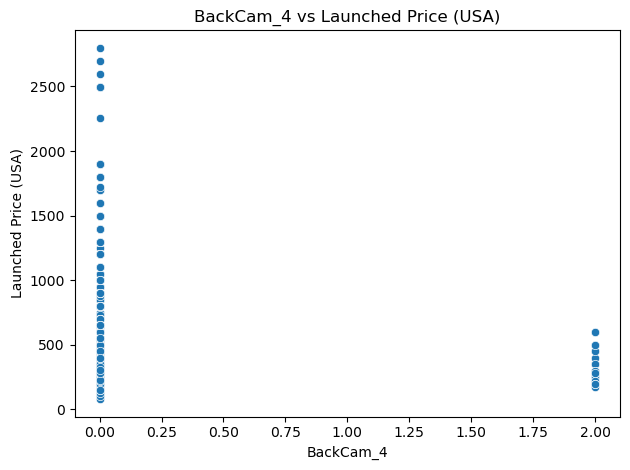

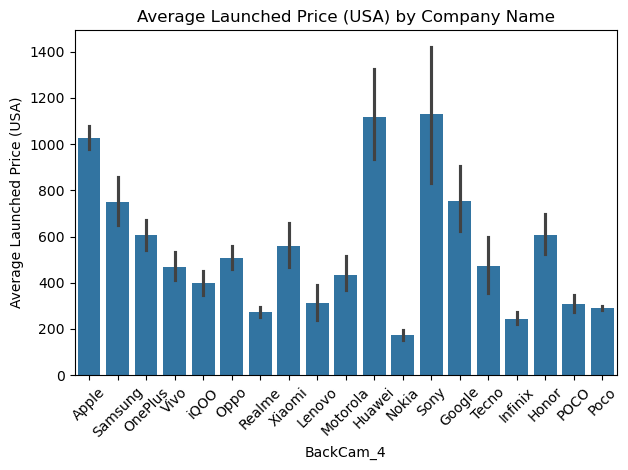

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

for feature in numerical_features:
    # scatterplot comparing feature to target variable, Launched Price (USA)
    sns.scatterplot(data=df, x=feature, y='Launched Price (USA)')
    plt.title(f'{feature} vs Launched Price (USA)')
    plt.xlabel(feature)
    plt.ylabel('Launched Price (USA)')
    plt.tight_layout()
    plt.show()

# barplot comparing feature to target variable, Launched Price (USA)
sns.barplot(data=df, x='Company Name', y='Launched Price (USA)', estimator='mean')
plt.title(f'Average Launched Price (USA) by Company Name')
plt.xlabel(feature)
plt.ylabel('Average Launched Price (USA)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Data Analysis

In [13]:
# Correlation
df.corr(numeric_only=True)['Launched Price (USA)'].sort_values(ascending=False)

Launched Price (USA)    1.000000
RAM                     0.466653
BackCam_2               0.327685
FrontCam_2              0.248167
BackCam_3               0.245346
Mobile Weight           0.111078
Screen Size             0.091177
BackCam_1               0.079715
FrontCam_1              0.072105
Launched Year           0.053451
Battery Capacity       -0.029164
BackCam_4              -0.082643
Name: Launched Price (USA), dtype: float64

In [14]:
# Central Tendency
df[['Launched Price (USA)'] + numerical_features].describe()

,Launched Price (USA),Mobile Weight,RAM,Battery Capacity,Screen Size,FrontCam_1,FrontCam_2,BackCam_1,BackCam_2,BackCam_3,BackCam_4
count,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000
mean,583.538924,228.011195,7.789020,5022.747040,7.080226,18.173950,0.254037,46.806028,5.905920,2.790097,0.043057
std,421.189917,105.199923,3.178956,1352.266507,1.530646,11.988038,1.183602,31.060553,11.465821,10.287467,0.290432
min,79.000000,135.000000,1.000000,2000.000000,5.000000,2.000000,0.000000,5.000000,0.000000,0.000000,0.000000
25%,250.000000,185.000000,6.000000,4400.000000,6.500000,8.000000,0.000000,16.000000,0.000000,0.000000,0.000000
50%,449.000000,194.000000,8.000000,5000.000000,6.670000,16.000000,0.000000,50.000000,0.000000,0.000000,0.000000
75%,849.000000,208.000000,8.000000,5065.000000,6.780000,32.000000,0.000000,50.000000,8.000000,0.000000,0.000000
max,2799.000000,732.000000,16.000000,11200.000000,14.600000,60.000000,12.000000,200.000000,64.000000,64.000000,2.000000


<Axes: xlabel='Launched Price (USA)', ylabel='Count'>

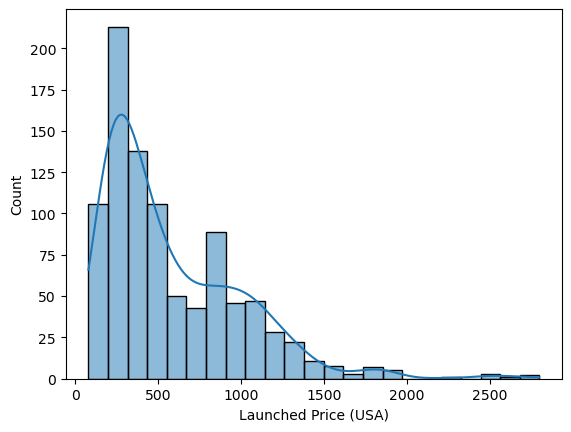

In [15]:
sns.histplot(df['Launched Price (USA)'], kde=True)


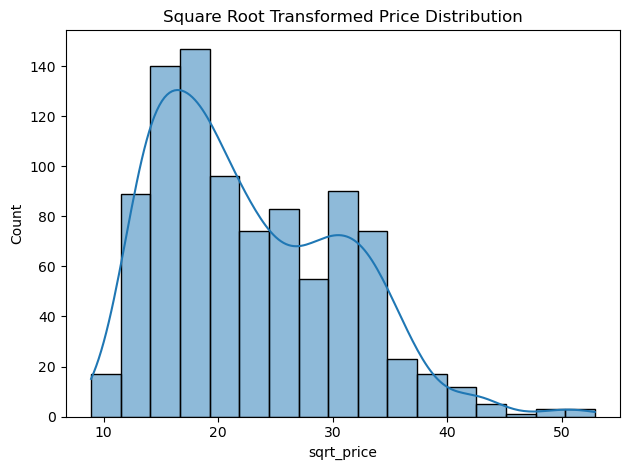

In [20]:
import numpy as np

df['sqrt_price'] = np.sqrt(df['Launched Price (USA)'])

sns.histplot(df['sqrt_price'], kde=True)
plt.title('Square Root Transformed Price Distribution')

plt.tight_layout()
plt.show()

#### Clustering Analysis

C:\Users\monted\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


<Axes: xlabel='Battery Capacity', ylabel='sqrt_price'>

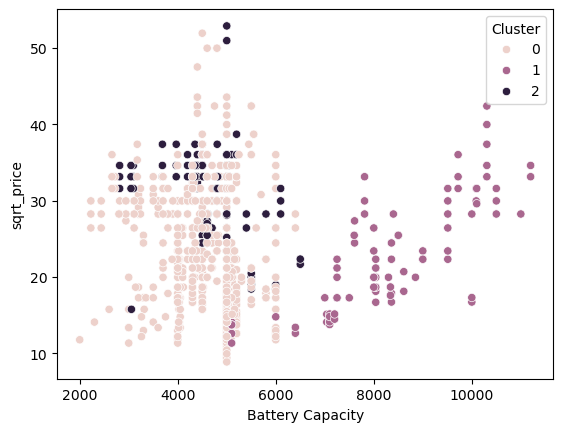

In [23]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features = df[numerical_features]
scaled = StandardScaler().fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled)
df['Cluster'] = clusters

sns.scatterplot(data=df, x='Battery Capacity', y='sqrt_price', hue='Cluster')


#### Data Modeling and Prediction:
Assess which variable shows statistically significant association.

#### Greedy Feature Linear Regression Model
- i. Build a model for each variable individually.
- ii. Sort the variables using residual sum of squares mean.
- iii. Starting with the baseline model, add each variable one at a time to the
model. If variable improves the sum of squares mean over the last model, keep that
variable in the model. At the end, you should have a single model with
multiple variables

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

rss_list = []
for feature in X_train.columns:
    model = LinearRegression()
    model.fit(X_train[[feature]], y_train)
    preds = model.predict(X_test[[feature]])
    rss = mean_squared_error(y_test, preds) * len(y_test)  # RSS = MSE * n
    rss_list.append((feature, rss))


In [27]:
sorted_features = sorted(rss_list, key=lambda x: x[1])  # lower is better

In [31]:
selected = []
best_rss = float('inf')

for feature, _ in sorted_features:
    try_features = selected + [feature]
    model = LinearRegression()
    model.fit(X_train[try_features], y_train)
    preds = model.predict(X_test[try_features])
    rss = mean_squared_error(y_test, preds) * len(y_test)

    if rss < best_rss:
        selected.append(feature)
        best_rss = rss
selected

['RAM',
 'FrontCam_2',
 'BackCam_2',
 'BackCam_4',
 'FrontCam_1',
 'Battery Capacity',
 'BackCam_1',
 'Mobile Weight']

#### Baseline Linear Regression Model
Average the launch price and calculate the residual sum of squares mean

In [34]:
# Predict average price for all test samples (baseline)
baseline_preds = [y_train.mean()] * len(y_test)


In [36]:
X = df[selected]
y = df['Launched Price (USA)']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
model_preds = model.predict(X_test)


#### Compute Squared Errors and Perform t-Test

In [39]:
from scipy.stats import ttest_rel

# Calculate squared errors
baseline_sq_errors = (y_test - baseline_preds) ** 2
model_sq_errors = (y_test - model_preds) ** 2

# Paired t-test (alternative: model error < baseline error)
t_stat, p_value = ttest_rel(model_sq_errors, baseline_sq_errors, alternative='less')

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


T-statistic: -5.203924397520046
P-value: 2.5764587285222265e-07


#### Results Analysis:
- T-statistic = -5.203924397520046
> This value indicates that the mean squared error (MSE) of the model is lower than the baseline and the difference is statistically meaningful.
> A negative t-stat makes sense because we're testing if feature model error < baseline error.

- P-value = 2.5764587285222265e-07
> There is a 0.02% probability that we would observe such a strong improvement in MSE by chance if the model and baseline were equally good.
> Since 0.0002 < 0.05, this is statistically significant at the 5% level (commonly used threshold).

- We reject the null hypothesis and conclude that the features model outperforms the baseline (in terms of lower squared error).

# Improving analysis:
1. Improving camera representation: Instead of separate columns for each lens, finding a unified metric to account for the wide variation in camera counts would greatly improve the potential for the data.

2. Standardizing processor data: Develop a consistent encoding (e.g. a benchmark score) for processor models, since current names vary widely across manufacturers and have no consistent nomenclature.